Version 2.0 October 31st, 2023

# Oxygen corrections applied to delayed mode data
- deployment: dfo-mike579-20210704
- glider: dfo-mike579
- sensor: oxygen_0041
- calibration date: November 04, 2015
- description: Calvert Island Line

# 1.0 Preamble
This document describes dissolved oxygen data processing steps applied to delayed mode data collected using a Rinko ARO-CAR-Z10 dissolved oxygen optode mounted on a G2 Slocum autonomous ocean glider. This sensor is mounted on the bottom of the science bay hull in the middle of the glider, and measures % oxygen saturation. It has a response time of less than 1 s. When converting from % oxygen saturation to concentration, note that potential density is used. 

In [1]:
deploy_name = 'dfo-mike579-20210704'
glider_name = 'dfo-mike579'
deploy_prefix = './dfo-mike579-20210704/'
processing_report = 'Oxygen_dfo-mike579-20210704_v2'
processing_date = '20240328'
processing_protocol = 'C-PROOF_OxygenProcessingReport_v0.2.pdf'

In [2]:
# Set up our sensor-specific constants
optode = 'Rinko' #Which type of sensor is on the glider 'Aanderaa' or 'Rinko'
sn = '0041' #Sensor serial number
field = 'oxy' #Determines if we need to convert to phase before applying time lag correction, verify units are in uM (umol/L), options are 'oxy' or 'phase'
filt_name = 'Milo' #Type of filter to apply, options are 'Milo' and 'Boxcar'

## 1.1 Set up the processing

The processing steps below are applied to delayed mode data stored in a single netcdf timeseries file created using the Pyglider data processing package (https://github.com/c-proof/pyglider). This data has already undergone CTD sensor corrections. The metadata and a detailed report describing the corrections being applied will be made available via the deployment page on the C-PROOF website: https://cproof.uvic.ca/gliderdata/deployments/dfo-mike579/dfo-mike579-20210704/.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import numpy as np
import pathlib

from datetime import datetime, timedelta

import time 
import tqdm

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import scipy.stats as stats
from scipy.interpolate import interp1d

import pandas as pd
import csv
import seawater

%load_ext autoreload
%autoreload 2

In [4]:
ds = xr.open_dataset(f'{deploy_prefix}/{deploy_name}_adjusted.nc')

In [5]:
ds

<xarray.Dataset>
Dimensions:                (time: 1195042)
Coordinates:
  * time                   (time) datetime64[ns] 2021-07-04T17:58:49 ... 2021...
    latitude               (time) float64 ...
    longitude              (time) float64 ...
    depth                  (time) float64 ...
    pind                   (time) float64 ...
    profiles               float64 ...
Data variables: (12/25)
    heading                (time) float64 ...
    pitch                  (time) float64 ...
    roll                   (time) float64 ...
    waypoint_latitude      (time) float64 ...
    waypoint_longitude     (time) float64 ...
    conductivity           (time) float64 ...
    ...                     ...
    profile_index          (time) float64 ...
    profile_direction      (time) float64 ...
    conductivity_adjusted  (time) float64 ...
    temperature_adjusted   (time) float64 ...
    salinity_adjusted      (time) float64 ...
    density_adjusted       (time) float64 ...
Attributes: (12/65)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from Fisheries and Oceans Canada, Cana...
    cdm_data_type:             Trajectory
    comment:                   Calvert Island deployment
    contributor_name:          Hayley Dosser, Chris Payne, Stephanie Waterman
    ...                        ...
    summary:                   Glider deployed near Calvert Island BC in coll...
    time_coverage_end:         2021-08-04T00:10:45.000000000
    time_coverage_start:       2021-07-04T17:58:49.000000000
    title:                     dfo-mike579-20210704T1758
    transmission_system:       IRIDIUM
    wmo_id:                    4803927

In [7]:
ds.oxygen_concentration

<xarray.DataArray 'oxygen_concentration' (time: 3236090)>
[3236090 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2022-05-31T16:41:13 ... 2022-09-15T11:40:11
    latitude   (time) float64 ...
    longitude  (time) float64 ...
    depth      (time) float64 ...
    pind       (time) float64 ...
Attributes:
    source:               sci_oxy4_oxygen
    long_name:            oxygen concentration
    standard_name:        mole_concentration_of_dissolved_molecular_oxygen_in...
    units:                umol l-1
    comment:               
    accuracy:              
    precision:             
    platform:             platform
    resolution:            
    ancillary_variables:

In [6]:
if field == 'oxy' and optode == 'Rinko' and sn == '0041':
    print('Loading coefficients for Rinko sensor')
# Rinko sensor 0041 on Mike is one of only two ARO-CAR optodes in the fleet

# From the calibration sheet:
# A = -42.99396
# B = 2268689.2
# C = -6296.315
# D = 0.01001100
E = 0.00440000
# F = 0.00005380
# G = 0.0
# H = 1.0

else:
    print('Verify sensor information and calibration coefficients are correct!')

# 2.0 Corrections applied to delayed mode data for this mission
This document covers the following steps:
1. Correct for pressure effects
2. Convert from %-saturation to concentration in $\mu$mol/L
3. Determine the sensor response time lag correction
4. Apply the sensor response time lag correction
5. Determine the optode drift correction
6. Apply the optode drift correction

## 2.1 Correct for pressure effects

The Rinko II ARO-CAR optode manual states: "The instrument measures changes in phosphorescence life time due to changes in oxygen partial pressure. Since phosphorescence life time is affected by temperature and pressure, it is necessary to measure these variables at the same time in order to convert to saturation. Temperature is obtained using the instrument's integrated thermistor. However, pressure must be provided separately by the user. In addition, salinity data must be provided by the user in order to convert % of saturation to other physical units such as mgL$^{-1}$ or $
\mu$molL$^{-1}$."

No information is given in the Rinko II manual on how to do this. 
On the calibration sheet, it says: DO[%] = $G + H \times P'$ - "Here, $P'$[%] consists of the coefficients A-F determined by the initial calibration." (The calibration is performed at atmospheric pressure.)

Then, in the Rinko III ARO-CAV manual, it states: 

$P = G + H \times P'$ (where $G$ and $H$ are parameters provided by the manufacturer and $P'$ is the uncalibrated output determined from the raw data using the thermistor temperature and coefficients $A$ through $D$ and $F$.) 

"The above $P$ is DO value in % without consideration on the effect by pressure, which can be corrected as, 

$P_d = P(1 + E \times d)$

Here $d$ is pressure in MPa and $E$ is a parameter provided by the manufacturer. Then, $P_d$ is DO in percentage with correction on temperature and pressure."

From this, we infer that the temperature correction is applied internally on the sensor, and it remains for us to apply the pressure correction. 

In [ ]:
# First step - pressure correction
# term1 = A/(1 + D*(ds.temperature_adjusted-25))
# term2 = B/((ds.oxygen_saturation-F)*(1 + D*(ds.temperature_adjusted-25)) + C + F)
# P_prime = term1 + term1
# P = G + H*P_prime
P = ds.oxygen_saturation
Pd = P*(1 + E*ds.pressure*0.01)

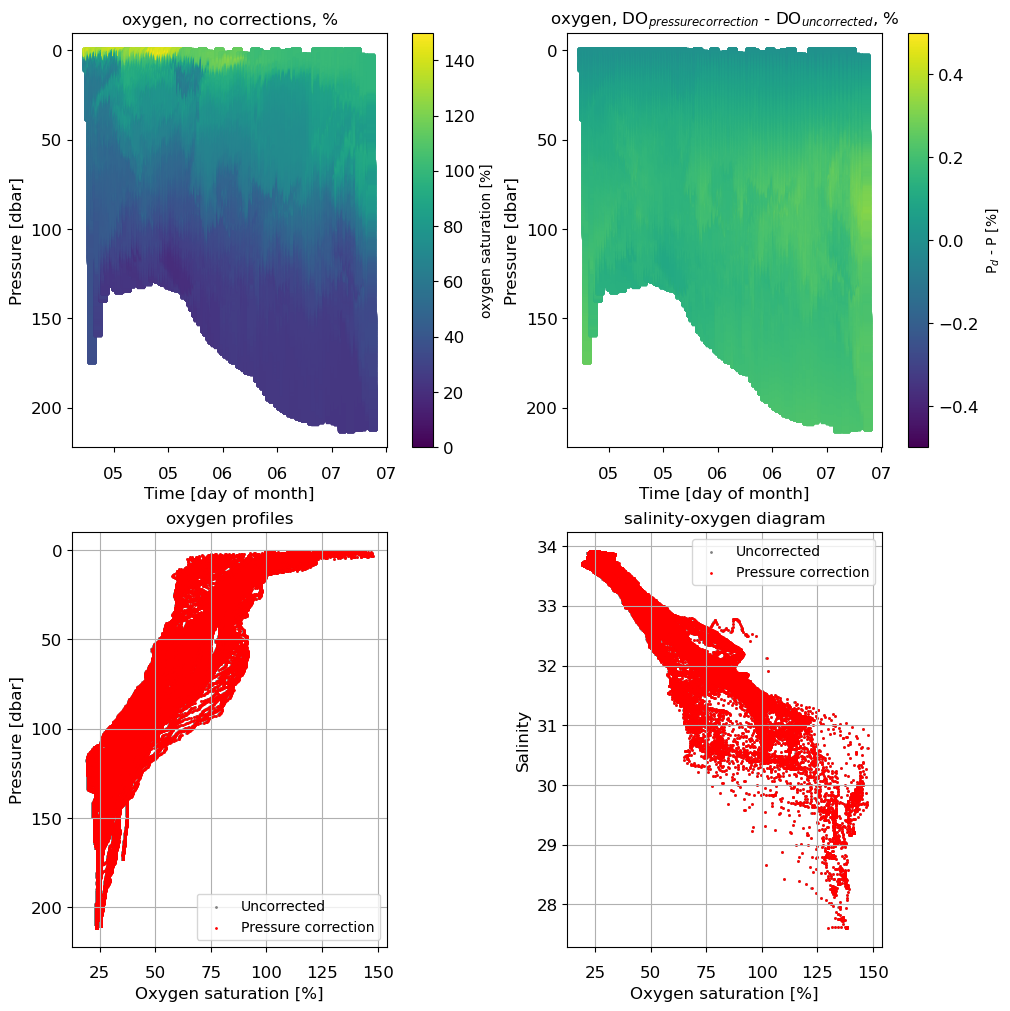

In [7]:
#Visualizing the corrections
fld = Pd[0:min([len(Pd), 100000])]
dp = ds.pressure[0:min([len(fld), 100000])]
tm = ds.time[0:min([len(fld), 100000])]
fld_orig = ds.oxygen_saturation[0:min([len(fld), 100000])]
sal = ds.salinity_adjusted[0:min([len(fld), 100000])]

fig, ax = plt.subplots(2,2,constrained_layout=True, 
                            figsize=(10, 10))
ax0 = ax[0,0]
sc = ax0.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, c=fld_orig[~np.isnan(fld)], marker='s', vmin=0, vmax=150)
cb0 = plt.colorbar(sc, ax=ax0, orientation='vertical', label='oxygen saturation [%]')
cb0.ax.tick_params(labelsize=12)
ax0.set_title('oxygen, no corrections, %')
ax0.set_xlabel('Time [day of month]',fontsize=12)
ax0.set_ylabel('Pressure [dbar]',fontsize=12)
ax0.invert_yaxis()
ax0.tick_params(labelsize=12)
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax0.xaxis.set_tick_params(which='major', pad=10)

ax1 = ax[0,1]
sc = ax1.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, c=fld[~np.isnan(fld)]-fld_orig[~np.isnan(fld)], marker='s', vmin=-0.5, vmax=0.5)
cb1 = plt.colorbar(sc, ax=ax1, orientation='vertical', label='P$_d$ - P [%]')
cb1.ax.tick_params(labelsize=12)
ax1.set_title('oxygen, DO$_{pressure correction}$ - DO$_{uncorrected}$, %')
ax1.set_xlabel('Time [day of month]',fontsize=12)
ax1.set_ylabel('Pressure [dbar]',fontsize=12)
ax1.invert_yaxis()
ax1.tick_params(labelsize=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax1.xaxis.set_tick_params(which='major', pad=10)

ax2 = ax[1,0]
ax2.grid()
ax2.scatter(fld_orig[~np.isnan(fld)], dp[~np.isnan(fld)],  s=1, c='gray', label='Uncorrected')
sc = ax2.scatter(fld[~np.isnan(fld)], dp[~np.isnan(fld)], s=1, c='r', label='Pressure correction')
ax2.legend()
ax2.set_title('oxygen profiles')
ax2.set_xlabel('Oxygen saturation [%]',fontsize=12)
ax2.set_ylabel('Pressure [dbar]',fontsize=12)
ax2.invert_yaxis()
ax2.tick_params(labelsize=12)
ax2.xaxis.set_tick_params(which='major', pad=10)

ax3 = ax[1,1]
ax3.grid()
ax3.scatter(fld_orig[~np.isnan(fld)], sal[~np.isnan(fld)], s=1, c='gray', label='Uncorrected')
sc = ax3.scatter(fld[~np.isnan(fld)], sal[~np.isnan(fld)], s=1, c='r', label='Pressure correction')
ax3.legend()
ax3.set_title('salinity-oxygen diagram')
ax3.set_xlabel('Oxygen saturation [%]',fontsize=12)
ax3.set_ylabel('Salinity',fontsize=12)
ax3.tick_params(labelsize=12)
ax3.xaxis.set_tick_params(which='major', pad=10)

## 2.2 Convert oxygen saturation [%] to concentration [$\mu$molL$^{-1}$]
Oxygen saturation is the ratio of the concentration of dissolved oxygen to the maximum amount of oxygen that can be dissolved at a given temperature and pressure - the oxygen solubility in sea water (e.g., Bittig et al., 2015). 

In [8]:
def O2sol(S,T):
# O2sol   Solubility of O2 in sea water
#=========================================================================
# O2sol Version 1.1 4/4/2005 converted to Python by Hayley Dosser in 2023
# USAGE:  concO2 = O2sol(S,T)
# DESCRIPTION:
#    Solubility (saturation) of oxygen (O2) in sea water
#    at 1-atm pressure of air including saturated water vapor
# INPUT:  (if S and T are not singular they must have same dimensions)
#   S = salinity    [PSS]
#   T = temperature [degree C]
# OUTPUT:
#   concO2 = solubility of O2  [umol/kg]  
# AUTHOR:  Roberta Hamme (rhamme@ucsd.edu) in Matlab
# REFERENCE:
#    Hernan E. Garcia and Louis I. Gordon, 1992.
#    "Oxygen solubility in seawater: Better fitting equations"
#    Limnology and Oceanography, 37, pp. 1307-1312.
#=========================================================================

    # convert T to scaled temperature
    temp_S = np.log((298.15 - T)/(273.15 + T));

    # constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
    A0_o2 = 5.80871; 
    A1_o2 = 3.20291;
    A2_o2 = 4.17887;
    A3_o2 = 5.10006;
    A4_o2 = -9.86643e-2;
    A5_o2 = 3.80369;
    B0_o2 = -7.01577e-3;
    B1_o2 = -7.70028e-3;
    B2_o2 = -1.13864e-2;
    B3_o2 = -9.51519e-3;
    C0_o2 = -2.75915e-7;

    # Corrected Eqn (8) of Garcia and Gordon 1992
    conc_O2 = np.exp(A0_o2 + A1_o2*temp_S + A2_o2*temp_S**2 + A3_o2*temp_S**3 + A4_o2*temp_S**4 + A5_o2*temp_S**5 + S*(B0_o2 + B1_o2*temp_S + B2_o2*temp_S**2 + B3_o2*temp_S**3) + C0_o2*S**2);

    return conc_O2

In [9]:
# Convert oxygen saturation to oxygen concentration

#Get seawater Solubility
OSat = O2sol(ds.salinity_adjusted, ds.temperature_adjusted);

#We divide by 100 to move from %-saturation to saturation
#We convert OSat from umol/kg to umol/L by multiplying by potential density
#We divide by 1000 to convert from potential density in kg/m^3 to kg/L

# Confirm input is in percentage of saturation
ds['oxygen_concentration'] = OSat*Pd*ds.potential_density/(100*1000)
#in units = 'umol/L'

In [10]:
ds.oxygen_concentration

<xarray.DataArray 'oxygen_concentration' (time: 1195042)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time       (time) datetime64[ns] 2021-07-04T17:58:49 ... 2021-08-04T00:10:45
    latitude   (time) float64 ...
    longitude  (time) float64 ...
    depth      (time) float64 ...
    pind       (time) float64 ...
    profiles   float64 ...

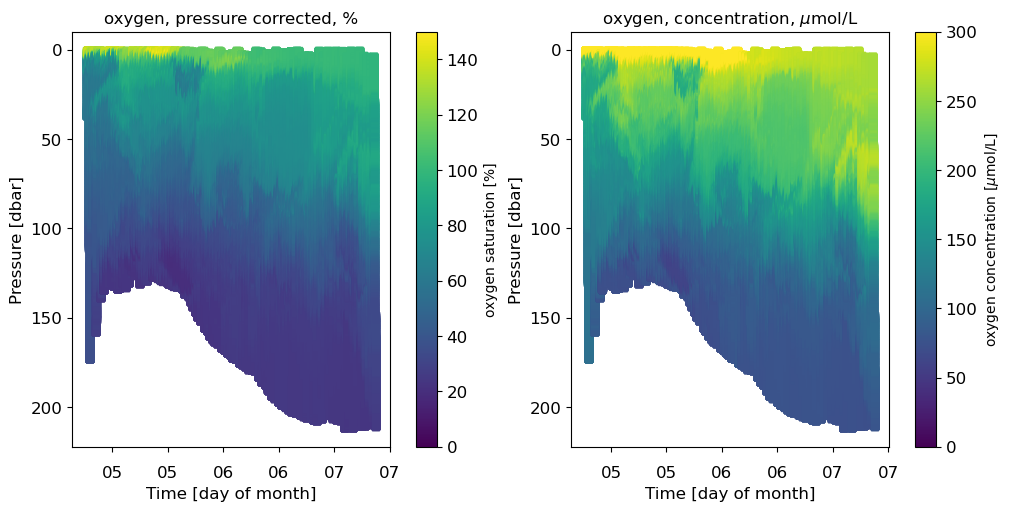

In [11]:
#Visualizing the corrections
fld_orig = Pd[0:min([len(Pd), 100000])]
fld = ds.oxygen_concentration[0:min([len(Pd), 100000])]
dp = ds.pressure[0:min([len(fld), 100000])]
tm = ds.time[0:min([len(fld), 100000])]
sal = ds.salinity_adjusted[0:min([len(fld), 100000])]

fig, ax = plt.subplots(1,2,constrained_layout=True, 
                            figsize=(10, 5))
ax0 = ax[0]
sc = ax0.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, c=fld_orig[~np.isnan(fld)], marker='s', vmin=0, vmax=150)
cb0 = plt.colorbar(sc, ax=ax0, orientation='vertical', label='oxygen saturation [%]')
cb0.ax.tick_params(labelsize=12)
ax0.set_title('oxygen, pressure corrected, %')
ax0.set_xlabel('Time [day of month]',fontsize=12)
ax0.set_ylabel('Pressure [dbar]',fontsize=12)
ax0.invert_yaxis()
ax0.tick_params(labelsize=12)
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax0.xaxis.set_tick_params(which='major', pad=10)

ax1 = ax[1]
sc = ax1.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, c=fld[~np.isnan(fld)], marker='s', vmin=0, vmax=300)
cb1 = plt.colorbar(sc, ax=ax1, orientation='vertical', label='oxygen concentration [$\mu$mol/L]')
cb1.ax.tick_params(labelsize=12)
ax1.set_title('oxygen, concentration, $\mu$mol/L')
ax1.set_xlabel('Time [day of month]',fontsize=12)
ax1.set_ylabel('Pressure [dbar]',fontsize=12)
ax1.invert_yaxis()
ax1.tick_params(labelsize=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax1.xaxis.set_tick_params(which='major', pad=10)

## 2.3 Determine the sensor reponse time lag correction
The sensor response time lag correction is best applied to phase, but for the Rinko ARO-CAR sensor we are limited to applying it to dissolved oxygen concentration. To determine the correction to be applied, upcasts are compared to downcasts in order to estimate a time lag $\tau$. A least squares regression is then applied to the full time series.

Bittig et al., 2014 provides typical values of $\tau$. Given the rapid response time of Rinko sensors, it is expected that $\tau$ may be too small to necessitate applying a time lag correction. We verify this below. 

In [12]:
# Third step: Compare upcasts and downcasts to estimate time lag tau
# This step calculates the sensor response time lag using a least squares 
# regression on the whole timeseries. 

if field == 'phase':
    field_oxy = oxygen_phase
else:
    field_oxy = ds.oxygen_concentration

dz_mean = np.nanmean(np.abs(np.diff(ds.depth))) # average distance between samples in depth 

# calculate tau based on whole timeseries

#set up fields
upcast_field_interp = np.array([])
downcast_field_interp = np.array([])
upcast_time_interp = np.array([])#.astype("datetime64[s]")
downcast_time_interp = np.array([])#.astype("datetime64[s]")
z_full = np.array([])
i_bad = np.array([])

#set up variables we'll need 
dst = ds.copy()
dst['field_oxy'] = field_oxy #oxygen data
dst['pind'] = dst['pind'].astype('int') #profile index
dst['profile_direction'] = dst['profile_direction'].astype('int') #profile direction

#group the upcasts and downcasts
ds_group = dst.groupby('profile_direction')
upcasts = ds_group[-1]
downcasts = ds_group[1]
print('Grouping upcasts and downcasts, stand by.')

#ensure each downcast has a matching upcast
downcast_index = np.unique(downcasts.profile_index[np.isin(downcasts.profile_index, 
                                                           upcasts.profile_index-1, assume_unique=False)]).astype('int')
print('Grouping upcasts and downcasts complete.')

C:\Users\Hayley\miniconda3\envs\pyglider2\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Grouping upcasts and downcasts, stand by.
Grouping upcasts and downcasts complete.


In [13]:
#Interpolate the upcasts and downcasts to a consistent depth grid

print('Interpolating fields.')
for i in tqdm.tqdm(downcast_index):
    p=i
    dive_ind = np.where(downcasts.profile_index==p) #index of the downcast
    downcast_field = downcasts.field_oxy[dive_ind] #oxygen for the downcast
    downcast_z = downcasts.depth[dive_ind] #depth for the downcast
    downcast_time = downcasts.time[dive_ind] #time for the downcast

    # upcast
    climb_ind = np.where(upcasts.profile_index==p+1) #index of the upcast
    upcast_field = upcasts.field_oxy[climb_ind] #oxygen for the upcast
    upcast_z = upcasts.depth[climb_ind] #depth for the upcast
    upcast_time = upcasts.time[climb_ind] #time for the upcast

    # new depth array
    z_target = np.arange(np.nanmax([downcast_z[0], upcast_z[-1]]), np.nanmin([downcast_z[-1], upcast_z[0]]), dz_mean)

    try:
        # getting rid of any repeats in the depth
        upcast_z,I,_ = np.unique(upcast_z, return_index=True, return_counts=True) 
        upcast_field = upcast_field[I]
        upcast_time = upcast_time[I]
        downcast_z,I,_ = np.unique(downcast_z, return_index=True, return_counts=True)
        downcast_field = downcast_field[I]
        downcast_time = downcast_time[I]

        # interpolating upast and downcast to same depth grid
        upcast_field_interp = np.append(upcast_field_interp, np.interp(z_target, upcast_z[~np.isnan(upcast_z)], upcast_field[~np.isnan(upcast_z)]))
        downcast_field_interp = np.append(downcast_field_interp, np.interp(z_target, downcast_z[~np.isnan(downcast_z)], downcast_field[~np.isnan(downcast_z)]))

        # interpolate time to same grid            
        var_non_nan = upcast_time.values[~np.isnan(upcast_z)].astype("datetime64[s]")
        us_since_1970 = (var_non_nan - np.datetime64("1970-01-01").astype("datetime64[s]")).astype(np.int64) 
        time_int = np.interp(z_target, upcast_z[~np.isnan(upcast_z)], us_since_1970)
        upcast_time_interp = np.append(upcast_time_interp, time_int)          

        var_non_nan = downcast_time.values[~np.isnan(downcast_z)].astype("datetime64[s]")
        us_since_1970 = (var_non_nan - np.datetime64("1970-01-01").astype("datetime64[s]")).astype(np.int64)
        time_int = np.interp(z_target, downcast_z[~np.isnan(downcast_z)], us_since_1970)
        downcast_time_interp = np.append(downcast_time_interp, time_int)           

        # depth array to go with timeseries
        z_full = np.append(z_full, z_target)

    except Exception as e:
        raise e
        i_bad = np.append(i_bad, i)

        #filling bad tries with NaN
        upcast_field_interp = np.append(upcast_field_interp, np.nan*np.zeros(len(z_target)))
        downcast_field_interp = np.append(downcast_field_interp, np.nan*np.zeros(len(z_target)))

        upcast_time_interp = np.append(upcast_time_interp, np.nan*np.zeros(len(z_target)))
        downcast_time_interp = np.append(downcast_time_interp, np.nan*np.zeros(len(z_target)))

        z_full = np.append(z_full, z_target)


Interpolating fields.


100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [00:09<00:00, 78.00it/s]


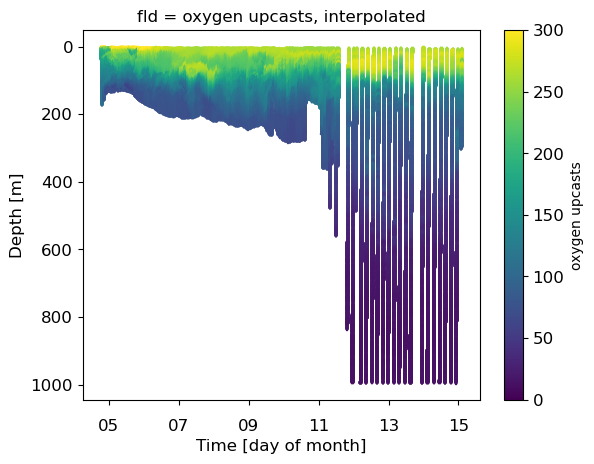

In [14]:
#Quick visualization to ensure interpolated fields look reasonable

fld = upcast_field_interp[:min(len(ds['oxygen_concentration']), 200000)]
dp = z_full[0:min([len(ds['oxygen_concentration']), 200000])]
tm = upcast_time_interp[0:min([len(ds['oxygen_concentration']), 200000])].astype("timedelta64[s]") + np.datetime64("1970-01-01").astype("datetime64[s]")
fig, ax = plt.subplots()
vmin = 0
vmax = 300
sc = ax.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=1, c=fld[~np.isnan(fld)], marker='s', cmap='viridis', vmin=vmin, vmax=vmax)
cb = plt.colorbar(sc, ax=ax, orientation='vertical', label='oxygen upcasts')
cb.ax.tick_params(labelsize=12)
ax.set_title('fld = oxygen upcasts, interpolated')
ax.set_xlabel('Time [day of month]',fontsize=12)
ax.set_ylabel('Depth [m]',fontsize=12)
ax.invert_yaxis()
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_tick_params(which='major', pad=10)
plt.show()

Now we use the upcasts and downcasts that have been interpolated to a regular depth grid to estimate $\tau$ using least-squares regression applied to the entire time series. 

In [15]:
# Determining tau from least-squares regression
up_field = upcast_field_interp.copy()
dn_field = downcast_field_interp.copy()

# Mask out bad data points with very small or very large dt values using a threshold
# don't want to include samples spaced apart by more than one standard deviation from the mean dt 
# shouldn't have any samples with less than 0.1 secs between them

#Upcasts
upcast_time_secs = upcast_time_interp
thrs = np.abs(np.gradient(upcast_time_secs)) > (np.nanmean(np.abs(np.gradient(upcast_time_secs))) + 
                                                np.nanstd(np.abs(np.gradient(upcast_time_secs))))
tlow = np.abs(np.gradient(upcast_time_secs)) < 0.1 
up_field[thrs] = np.nan
up_field[tlow] = np.nan

#Downcasts
downcast_time_secs = downcast_time_interp
thrs = np.abs(np.gradient(downcast_time_secs)) > (np.nanmean(np.abs(np.gradient(downcast_time_secs))) + 
                                                  np.nanstd(np.abs(np.gradient(downcast_time_secs))))
tlow = np.abs(np.gradient(downcast_time_secs)) < 0.1 
dn_field[thrs] = np.nan
dn_field[tlow] = np.nan

# Centered difference derivative wrt time
ind = ((~np.isnan(up_field)) & (~np.isnan(dn_field))).astype("bool") #find NaN values
dFdt_upcast = np.gradient(up_field[ind], upcast_time_secs[ind], edge_order=2)
dFdt_downcast = np.gradient(dn_field[ind], downcast_time_secs[ind], edge_order=2)

# Regression to find tau
ind_fit = ((~np.isnan(up_field[ind])) & (~np.isnan(dn_field[ind])) & (~np.isnan(dFdt_upcast)) & (~np.isnan(dFdt_downcast))).astype("bool")
y = up_field[ind][ind_fit] - dn_field[ind][ind_fit]
x = dFdt_upcast[ind_fit] - dFdt_downcast[ind_fit]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

tau = -slope
tau_99int = 2.58*std_err #The 99th percentile significance

print('Sensor response lag coefficient [in seconds] tau =', tau)
print('99th percentile significance =', tau_99int)
print('R-value for the linear regression =', r_value)

Sensor response lag coefficient [in seconds] tau = 1.695065665742324
99th percentile significance = 0.04310504474218639
R-value for the linear regression = -0.13547600557806355


## 2.4 Apply the sensor response time lag correction

The value for $\tau$ = 1.7s is small as expected, given the 1s response time of the sensor. We note that the least squares fit had a relatively low R-value, suggesting that the upcasts and downcasts were not offset by a consistent amount throughout the time series. Given this, we elect not to apply a sensor reponse time lag correction. This choice avoids applying the smoothing and filter required for this correction, better preserving the signals in the data. 

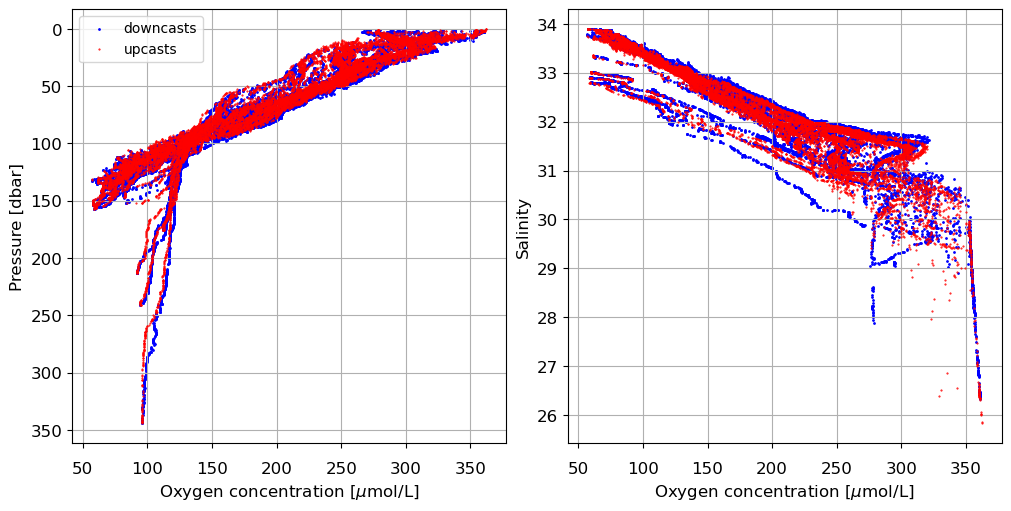

In [16]:
#Confirm the upcasts and downcasts are not offset by a significant amount

fld = ds.oxygen_concentration[0:min([len(oxygen_comp), 100000])]
dp = ds.pressure[0:min([len(fld), 100000])]
sal = ds.salinity_adjusted[0:min([len(fld), 100000])]

#Plotting
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))

ax0 = ax[0]
ind = np.where(ds.profile_direction.values[0:min([len(oxygen_comp), 100000])] == 1)[0]
ax0.scatter(fld[ind], dp[ind], s=1, c='b', label='downcasts')
ind = np.where(ds.profile_direction.values[0:min([len(oxygen_comp), 100000])] == -1)[0]
ax0.plot(fld[ind], dp[ind], 'r.', markersize=1, label='upcasts')
ax0.set_ylabel('Pressure [dbar]',fontsize=12)
ax0.set_xlabel('Oxygen concentration [$\mu$mol/L]',fontsize=12)
ax0.invert_yaxis()
ax0.tick_params(labelsize=12)
ax0.xaxis.set_tick_params(which='major', pad=10)
ax0.grid()
ax0.legend()

ax1 = ax[1]
ind = np.where(ds.profile_direction.values[0:min([len(oxygen_comp), 100000])] == 1)[0]
ax1.scatter(fld[ind], sal[ind], s=1, c='b', label='downcasts')
ind = np.where(ds.profile_direction.values[0:min([len(oxygen_comp), 100000])] == -1)[0]
ax1.plot(fld[ind], sal[ind], 'r.', markersize=1, label='upcasts')
ax1.set_ylabel('Salinity',fontsize=12)
ax1.set_xlabel('Oxygen concentration [$\mu$mol/L]',fontsize=12)
ax1.tick_params(labelsize=12)
ax1.xaxis.set_tick_params(which='major', pad=10)
ax1.grid()

In [ ]:
oxygen_correct = ds.oxygen_concentration

## 2.5 Determine the optode drift correction

The sensor drift correction is applied to the time-response corrected, compensated dissolved oxygen concentration data 'DO' to account for the tendency of oxygen optodes to drift over time as the sensor ages. Although drift increases as a function of the number of samples collected, sensors tend to drift more quickly during storage than while in the field by about a factor of 10. 

The sensor drift correction attempts to correct for the drift that does occur by comparing the oxygen optode data to a trustworth profile of dissolved oxygen concentration measurements collected nearby in space and time. Ideally, this comparison would be with Winkler titrated bottle samples collected at the same time and location as one of the glider’s dives. In practice, a hierarchy of ‘trustworthy’ data sources is used, within some chosen tolerance for distance and time from the glider’s sampling locations. 

The drift correction itself is a linear adjustment applied to DO\[$\mu$mol/kg\] with slope p1 and intercept p2: 

oxygen_concentration_adjusted \[$\mu$mol/kg\] = p1 DO\[$\mu$mol/kg\] + p2

Following Bittig et al., 2018, the drift is characterized by a reduced sensor response plus a small offset in the opposite direction. The slope should be positive, and within about 10\% of unity. The intercept should be within a few \[$\mu$mol/kg\] of zero and negative. In practice, the correction is determined with the intercept set to zero a priori. We have found that an intercept of zero typically produces better agreement in the near-surface mixed layer and in deep water, the most appropriate segments of the water column for comparison. 

If the slope is too large, the comparison may be rejected. It is expected that the drift for an individual sensor will increase with time (though not linearly). If this is not the case, or if a sudden large increase in drift is detected, the comparison should be re-evaluated and/or the sensor should be examined. 

To determine the drift correction, a least-squares fit is performed in density space between all of the suitable comparison profiles and the associated glider optode measurements. The glider profiles to be used are bin-averaged to the densities associated with the oxygen measurements from the comparison profile, with a bin size of +/-0.1 kg/m$^3$ (which can be adjusted higher if needed). The linear least-squares fit is applied to the binned oxygen optode measurements from the glider vs. the measurements from the comparison profile. The associated correlation coefficient for the fit is expected to be above r$^2$ = 0.95, and in practice is often above r$^2$ = 0.99.

Note that potential density is used, not in-situ density, since a given volume of water may move vertically by a significant amount due to isopycnal heaving, and we wish to remove this effect from the comparison. The portion of the profiles that is within the pycnocline is excluded from the comparison by visually identifying a depth at the base of the pycnocline and retaining only data below it, as well as data in the very near surface that will be close to the saturation value. 

The goodness of fit is evaluated by examining the agreement between the deep and shallow drift-corrected glider oxygen measurements with those from the comparison profile. For the shallowest measurements, the saturation value of oxygen at the comparison profile location is calculated and used to provide context for the expected near-surface oxygen concentration values. 

Finally, the linear sensor drift correction is applied to the DO measurements (not to the data binned by density). 

In [16]:
import re
import pandas as pd

# Fifth step: determine sensor drift by comparison with in-situ Winkler calibrated profiles, in potential density space
# Part 1: LOAD THE COMPARISON DATA

#Comparison with Hakai CTD cast or DFO bottle samples
#For each file:
org = 'hak'; #Specify if file is from Hakai (hak) or DFO ctd (dfo) or bottle sample (che)

#Load the comparison data into a pandas dataframe and confirm it's loaded correctly

df = pd.read_excel(f'{deploy_prefix}/8_binAvg_17369.xlsx', sheet_name='Data')
df.columns = [c.replace(' ', '_') for c in df.columns]
df.columns = [c.replace('(', '') for c in df.columns]
df.columns = [c.replace(')', '') for c in df.columns]
df.columns = [c.replace('/', '') for c in df.columns]

lonH = df.Longitude[0]
latH = df.Latitude[0]
timeH = df.Measurement_time[0]
depthH = df.Depth_m
print(df.Bottom_depth_m[0])
print(np.nanmax(df.Depth_m))
print(list(df))

TH =  df.Temperature_deg_C
SH = df.Salinity_PSU
PH = df.Pressure_dbar
OH = df.Dissolved_O2_mLL

print(TH)
print(SH)
print(OH)
RH = seawater.eos80.dens(SH, TH, PH)
RH0 = seawater.eos80.dens0(SH, TH)
OH = [val * 44.661 for val in OH]  # Convert units to umol/L

nan
397.712246594389
['Cast_PK', 'Cruise', 'Station', 'Station_Longitude', 'Station_Latitude', 'Latitude', 'Longitude', 'Distance_from_station', 'Location_Flag', 'Bottom_depth_m', 'Data_PK', 'Cast_Direction_Flag', 'Measurement_time', 'Depth_m', 'Depth_flag', 'Drop_speed_ms', 'Conductivity_mScm', 'Conductivity_flag', 'Temperature_deg_C', 'Temperature_flag', 'Pressure_dbar', 'Pressure_flag', 'PAR_umol_m-2_s-1', 'PAR_flag', 'Fluorometry_Chlorophyll_ugL', 'Fluorometry_Chlorophyll_flag', 'CDOM_ppb', 'CDOM_flag', 'Turbidity_FTU', 'Turbidity_flag', 'pH', 'pH_flag', 'Backscatter_Beta', 'Backscatter_flag', 'Dissolved_O2_mLL', 'Dissolved_O2_mLL_flag', 'SB_RINKO_Dissolved_O2_mLL', 'SB_RINKO_Dissolved_O2_flag', 'Salinity_PSU', 'Salinity_flag', 'Specific_conductivity', 'Specific_conductivity_flag', 'Speed_of_sound_ms', 'Speed_of_sound_flag', 'Beam_Attenuation_650nm_1m', 'Beam_Attenuation_flag', 'Bin_Statistics_for_Static_Casts']
0      12.367223
1      11.386741
2      10.911871
3      10.553404
4 

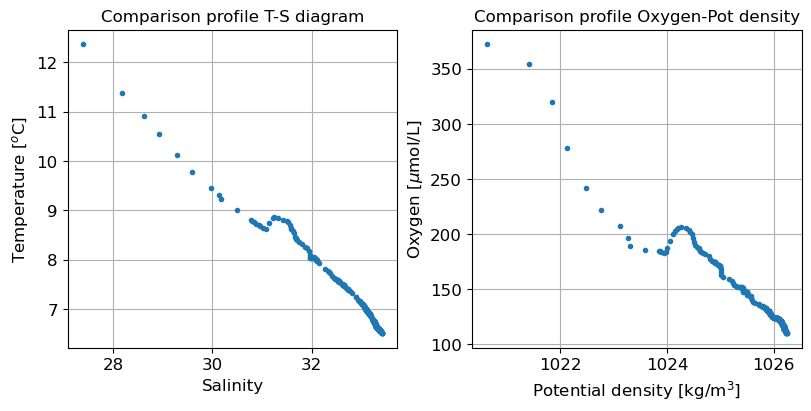

In [17]:
#Visualize the comparison profile
fig, ax = plt.subplots(1,2,constrained_layout=True, 
                            figsize=(8, 4))

ax[0].plot(SH,TH,'.')
ax[0].grid()
ax[0].set_title('Comparison profile T-S diagram')
ax[0].set_xlabel('Salinity',fontsize=12)
ax[0].set_ylabel('Temperature [$^o$C]',fontsize=12)
ax[0].tick_params(labelsize=12)

ax[1].plot(RH0,OH,'.')
ax[1].grid()
ax[1].set_title('Comparison profile Oxygen-Pot density')
ax[1].set_xlabel('Potential density [kg/m$^3$]',fontsize=12)
ax[1].set_ylabel('Oxygen [$\mu$mol/L]',fontsize=12)
ax[1].tick_params(labelsize=12)

In [18]:
# Compare to closest time and location
# Find closest glider profiles in time and space 

# Set a depth cutoff based on the depth of the comparison profile
zmax = 150 #Glider profile must extend deeper than this for comparison

# Set up glider fields for comparison
OO = oxygen_correct
dens = ds.longitude.copy()*np.nan
dens[:] = seawater.eos80.dens(ds.salinity_adjusted, ds.temperature_adjusted, ds.pressure)
dens0 = seawater.eos80.dens0(ds.salinity_adjusted, ds.temperature_adjusted)
lon = ds.longitude.values
lat = ds.latitude.values

#Calculate the distance between the comparison profile and each ocean glider profile
dist = np.empty_like(ds.longitude.values)*np.nan
p_ind = np.unique(ds.profile_index)
for i, p in enumerate(p_ind[0:100]):#p_ind>0]):
    if ~np.isnan(p):
        dist[ds.profile_index.values==p] = seawater.dist([np.nanmean(lon[ds.profile_index.values==p]), lonH], 
                                                         [np.nanmean(lat[ds.profile_index.values==p]), latH], units='km')[0][0]
        if np.nanmax(ds.depth[ds.profile_index.values==p])<zmax:
            dist[ds.profile_index.values==p] = dist[ds.profile_index.values==p]*np.nan
            
#Store fields in a new xarray for comparison 
ds_tmp = ds.copy(deep=True)
ds_tmp['dist'] = ('time', dist)
ds_tmp['oxy_cor'] = oxygen_correct
ds_tmp['dens'] = dens
ds_tmp['dens0'] = ('time', dens0)

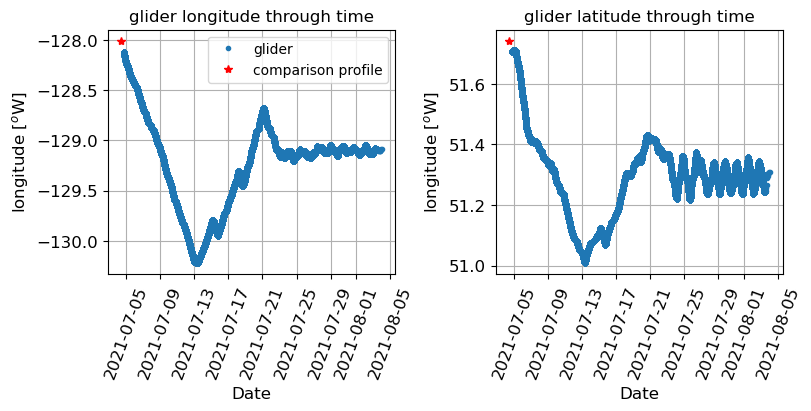

In [19]:
fig, ax = plt.subplots(1,2,constrained_layout=True, 
                            figsize=(8, 4))

ax[0].plot(ds.time,ds.longitude,'.',label='glider')
ax[0].plot(pd.to_datetime(timeH),lonH,'r*',label='comparison profile')
ax[0].grid()
ax[0].set_title('glider longitude through time')
ax[0].tick_params(axis='x',rotation=70)
ax[0].set_xlabel('Date',fontsize=12)
ax[0].set_ylabel('longitude [$^o$W]',fontsize=12)
ax[0].tick_params(labelsize=12)
ax[0].legend()

ax[1].plot(ds.time,ds.latitude,'.')
ax[1].plot(pd.to_datetime(timeH),latH,'r*')
ax[1].grid()
ax[1].set_title('glider latitude through time')
ax[1].tick_params(axis='x',rotation=70)
ax[1].set_xlabel('Date',fontsize=12)
ax[1].set_ylabel('longitude [$^o$W]',fontsize=12)
ax[1].tick_params(labelsize=12)

In [20]:
#Pull out a small amount of glider data for comparison
min_dist = 10 # This is how close the profile must be in km
min_time = 1 # 2 x min_time is how close the profile must be in days

dist_tmp = ds_tmp.where(ds_tmp.dist<(ds_tmp.dist.min(skipna=True)+min_dist))
time_lower = pd.to_datetime(timeH) - timedelta(days=min_time)
time_upper = pd.to_datetime(timeH) + timedelta(days=min_time)
tmp_sub = dist_tmp.sel(time=slice(time_lower,time_upper))
print('Number of glider profiles available for comparison', len(np.unique(tmp_sub.profile_index)))
print('Profile indices of profile(s) available for comparison', np.unique(tmp_sub.profile_index))

Number of glider profiles available for comparison 4
Profile indices of profile(s) available for comparison [2. 3. 6. 7.]


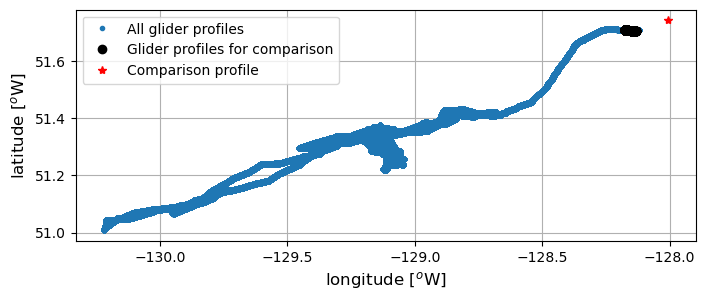

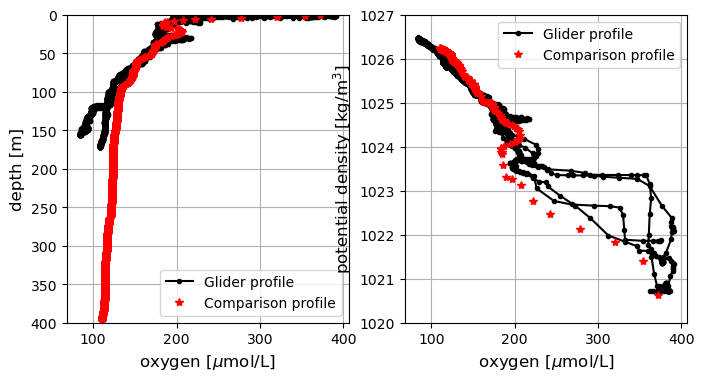

In [21]:
#Plotting the coordinates
lon_fin = tmp_sub.longitude.values
lat_fin = tmp_sub.latitude.values
plt.figure(figsize=(8,3))
plt.plot(lon, lat, '.', label='All glider profiles')
plt.plot(lon_fin, lat_fin, 'ok', label='Glider profiles for comparison')
plt.plot(lonH, latH, 'r*', label='Comparison profile')
plt.ylabel('latitude [$^o$W]',fontsize=12)
plt.xlabel('longitude [$^o$W]',fontsize=12)
plt.legend()
plt.grid()

# Plotting the data
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(tmp_sub.oxy_cor.values, tmp_sub.depth.values, 'k.-', label='Glider profile')
axs[0].plot(OH, depthH, 'r*', label='Comparison profile')
axs[0].set_ylim(400,0)
axs[0].set_ylabel('depth [m]',fontsize=12)
axs[0].set_xlabel('oxygen [$\mu$mol/L]',fontsize=12)
axs[0].grid()
axs[0].legend()

axs[1].plot(tmp_sub.oxy_cor.values, tmp_sub.dens0.values, 'k.-', label='Glider profile')
axs[1].plot(OH, RH0, 'r*', label='Comparison profile')
axs[1].set_ylim(1020,1027)
axs[1].set_ylabel('potential density [kg/m$^3$]',fontsize=12)
axs[1].set_xlabel('oxygen [$\mu$mol/L]',fontsize=12)
axs[1].grid()
axs[1].legend()

Examining the comparison profile and the glider data selected for comparison, we see high variability for densities between 1021.5 and 1024.5 kg/m$^3$. This comparison profile is not ideal - the glider dives were relatively shallow, and the collection location in Hakai Pass is a dynamic tidal channel. However, no other data are available for comparison. As such, we select the glider profile that most closely matches the comparison profile, glider profile index #3, and remove all data points with a density less than 1024.5 kg/m$^3$.

In [22]:
#Select desired glider profile for comparison
prof_ind = 3
tmp_sub = tmp_sub.where(tmp_sub.profile_index==prof_ind, drop=True)

#Set up your density limits and bins
rho_low = 1024.5 #include the whole profile since it's shallow
rho_high = 1027

#Choose cutoff densities and apply to comparison profile
rho_cut = np.logical_and(RH0>rho_low, RH0<rho_high)
rbin = RH0[rho_cut] #potential density
obin = np.array(OH)[rho_cut]

#Bin glider data to bottle data densities with a tolerance of +/-tol kg/m3
tol = 0.2 #tolerance (as small as possible while avoiding gaps)
RRr = np.nan * np.zeros((len(rbin),)) #potential density
OOr = np.nan * np.zeros((len(rbin),))
PPr = np.nan * np.zeros((len(rbin),))

for j in range(len(rbin)):
    RRr[j] = np.nanmean(tmp_sub.dens0[np.logical_and(tmp_sub.dens0>=(rbin[j]-tol), tmp_sub.dens0<(rbin[j]+tol))])
    OOr[j] = np.nanmean(tmp_sub.oxy_cor[np.logical_and(tmp_sub.dens0>=(rbin[j]-tol), tmp_sub.dens0<(rbin[j]+tol))])
    PPr[j] = np.nanmean(tmp_sub.pressure[np.logical_and(tmp_sub.dens0>=(rbin[j]-tol), tmp_sub.dens0<(rbin[j]+tol))])

#Set up the fields to compare, converting to umol/kg using potential density
fldg = (OOr/RRr*1000) #Glider profile
fldH = (obin/rbin*1000) #Comparison profile

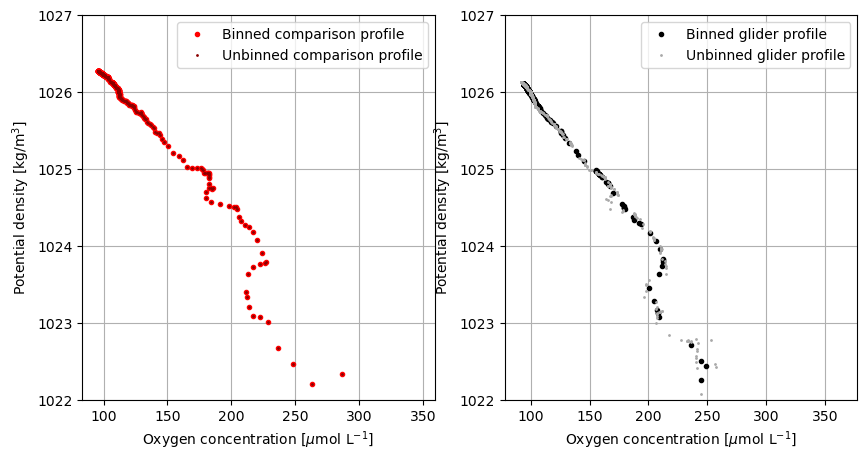

In [24]:
# Check that the binning worked properly
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(obin, rbin, 'r.', label='Binned comparison profile')
axs[0].plot(OH, RH0, '.', color='darkred', 
            markersize=2, label='Unbinned comparison profile')
axs[0].set_ylabel('Potential density [kg/m$^3$]') 
axs[0].set_xlabel('Oxygen concentration [$\mu$mol L$^{-1}$]')
axs[0].set_ylim(1024,1027) 
axs[0].grid()
axs[0].legend()

axs[1].plot(OOr, RRr, 'k.', label='Binned glider profile')
axs[1].plot(tmp_sub.oxy_cor.values[ind], tmp_sub.dens0.values[ind], '.', 
            color='darkgray', markersize=2, label='Unbinned glider profile')
axs[1].set_ylabel('Potential density [kg/m$^3$]') 
axs[1].set_xlabel('Oxygen concentration [$\mu$mol L$^{-1}$]')
axs[1].set_ylim(1024,1027) 
axs[1].grid()
axs[1].legend()

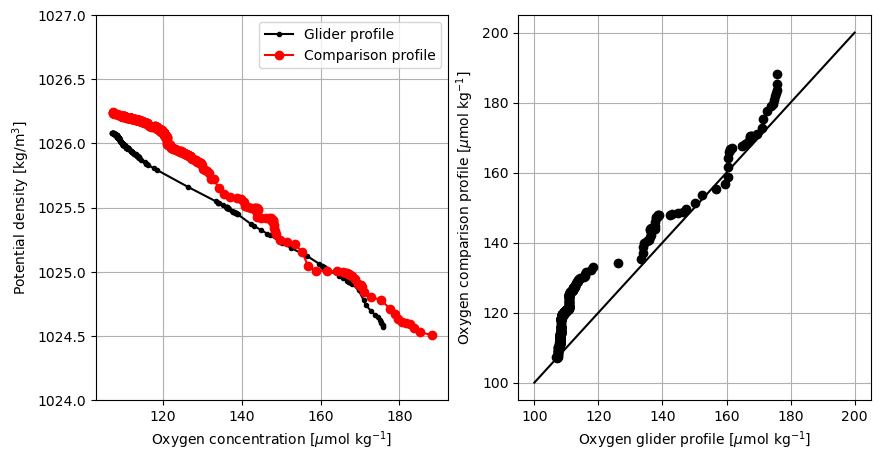

In [23]:
# Plotting the data
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(fldg, RRr, 'k.-', label='Glider profile')
axs[0].plot(fldH, rbin, 'ro-', label='Comparison profile')
axs[0].set_ylabel('Potential density [kg/m$^3$]') 
axs[0].set_xlabel('Oxygen concentration [$\mu$mol kg$^{-1}$]')
axs[0].set_ylim(1024,1027) 
axs[0].grid()
axs[0].legend()

axs[1].plot(fldg, fldH, 'ko')
axs[1].plot((100, 200), (100, 200), 'k-')
axs[1].set_ylabel('Oxygen comparison profile [$\mu$mol kg$^{-1}$]') 
axs[1].set_xlabel('Oxygen glider profile [$\mu$mol kg$^{-1}$]')
axs[1].grid()

We now apply a least-squares fit between the two profiles in isopycnal space. We force the intercept to pass through zero, as this has been demonstrated to result in more accurate corrections. As oxygen optodes drift, they tend to read lower values of oxygen [Bittig et al., 2015], so we expect the correction to produce a slight increase in oxygen concentration. 

In [24]:
# Forcing the intercept to go through ZERO
intercept_zero = True
if intercept_zero:
    mask = ~np.isnan(fldg) & ~np.isnan(fldH)
    p_zero = np.linalg.lstsq(fldg[mask].reshape(-1,1), fldH[mask], rcond=None)[0]
    x = np.arange(100, 200, 1) #Used for plotting
    Y = np.polyval([p_zero[0], 0], x)
    slope,intercept,R_val,p_val,stn_err = stats.linregress(fldg[mask], fldH[mask])

    print(f"slope m = {np.round(p_zero,2)} and R2 = {np.round(R_val**2,2)}")

slope m = [1.07]


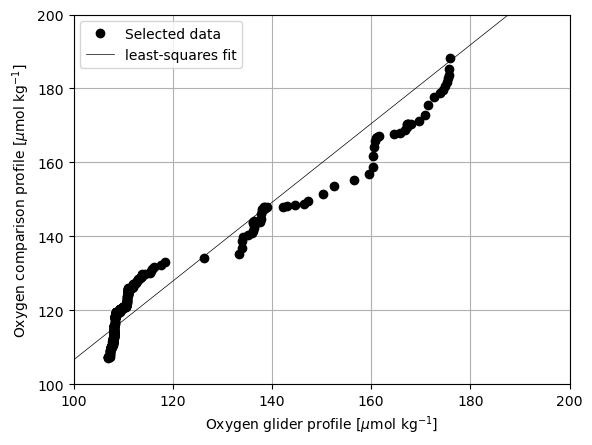

In [25]:
# Plotting the best fit line
plt.plot(fldg, fldH, 'ko', label='Selected data')
plt.plot(x, Y, 'k-', linewidth=0.5, label='least-squares fit')
plt.ylabel('Oxygen comparison profile [$\mu$mol kg$^{-1}$]') 
plt.xlabel('Oxygen glider profile [$\mu$mol kg$^{-1}$]')
plt.ylim(100, 200)
plt.xlim(100, 200)
plt.grid()
plt.legend()

### 2.6 Applying the optode drift correction 
**Sanity checks**
We now apply our drift correction and confirm that the drift correction has had the intended effect. We check the following:
1. Do we see better agreement with the full comparison profile, particularly in the deep water and at the surface?
2. Are values at the surface consistent with saturated (or over-satured) water?
3. Are values at 1000 m consistent with other deep oxygen samples?

In [26]:
# Apply the drift correction
if intercept_zero:
    oxygen_drift = (oxygen_correct / dens0 * 1000) * p_zero[0] #UNITS = umol/kg!

    # Set any unphysical values to NaN
oxygen_drift[np.logical_or(oxygen_drift > 500, oxygen_drift<0)] = np.nan

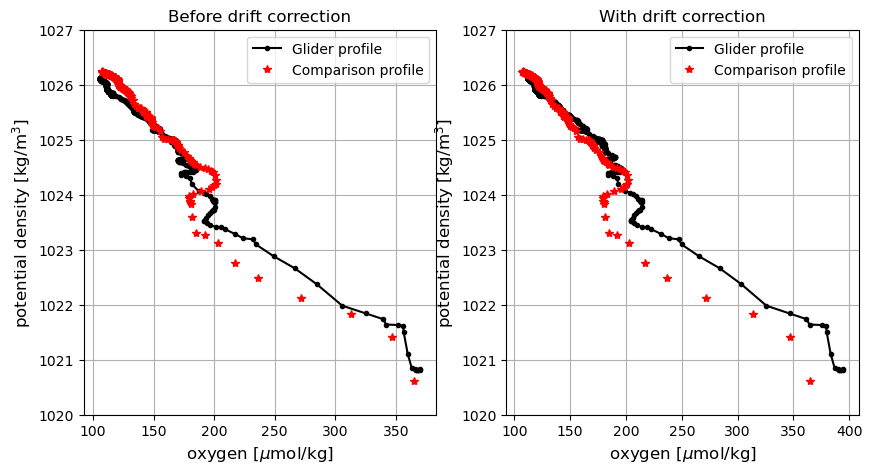

In [27]:
# Plotting the data without and with the drift comparison
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].set_title('Before drift correction')
axs[0].plot(tmp_sub.oxy_cor.values / tmp_sub.dens0.values * 1000, tmp_sub.dens0.values, 'k.-', label='Glider profile')
axs[0].plot(OH / RH0 * 1000, RH0, 'r*', label='Comparison profile')
axs[0].set_ylim(1020,1027)
axs[0].set_ylabel('potential density [kg/m$^3$]',fontsize=12)
axs[0].set_xlabel('oxygen [$\mu$mol/kg]',fontsize=12)
axs[0].grid()
axs[0].legend()

axs[1].set_title('With drift correction')
axs[1].plot(tmp_sub.oxy_cor.values / tmp_sub.dens0.values * 1000 * p_zero[0], tmp_sub.dens0.values, 'k.-', label='Glider profile')
axs[1].plot(OH / RH0 * 1000, RH0, 'r*', label='Comparison profile')
axs[1].set_ylim(1020,1027)
axs[1].set_ylabel('potential density [kg/m$^3$]',fontsize=12)
axs[1].set_xlabel('oxygen [$\mu$mol/kg]',fontsize=12)
axs[1].grid()
axs[1].legend()

**Agreement with comparison profile**: Unfortunately, the agreement with the comparison profile has worsened, particularly near the surface. By design, it has improved over the density range chosen to perform the correction.

In [1]:
# Plotting the data without and with the drift comparison
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].set_title('Before drift correction')
ax[0].plot(O2sol(SH,TH), depthH, '.', label='Oxygen saturation')
ax[0].plot(OH / RH0 * 1000, depthH, 'ro-', label='Comparison profile')
ax[0].plot(tmp_sub.oxy_cor.values / tmp_sub.dens0.values * 1000, tmp_sub.depth, 'k.-', label='Glider profile')
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Oxygen concentration [$\mu$mol kg$^{-1}$]')
ax[0].set_ylim(20, 0)
ax[0].legend()
ax[0].grid()

ax[1].set_title('After drift correction')
ax[1].plot(O2sol(SH,TH), depthH, '.', label='Oxygen saturation')
ax[1].plot(OH / RH0 * 1000, depthH, 'ro-', label='Comparison profile')
ax[1].plot(tmp_sub.oxy_cor.values / tmp_sub.dens0.values * 1000  * p_zero[0], tmp_sub.depth, 'k.-', label='Glider profile')
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Oxygen concentration [$\mu$mol kg$^{-1}$]')
ax[1].set_ylim(20, 0)
ax[1].grid()

NameError: name 'plt' is not defined

**Surface values**: Both the glider profile and comparison profile appear over-saturated at the surface. Before the drift correction, they are in good agreement, which is not the case after the correction is applied. At that point, the glider profile is closer to 100% saturation. This type of comparison provides information, but is not conclusive, particularly in a dynamic environment such as Hakai Pass, with profiles that were not co-located in space or time.

The minimum oxygen value before the drift correction is 12.1 umol/kg
The minimum oxygen value after the drift correction is 12.9 umol/kg


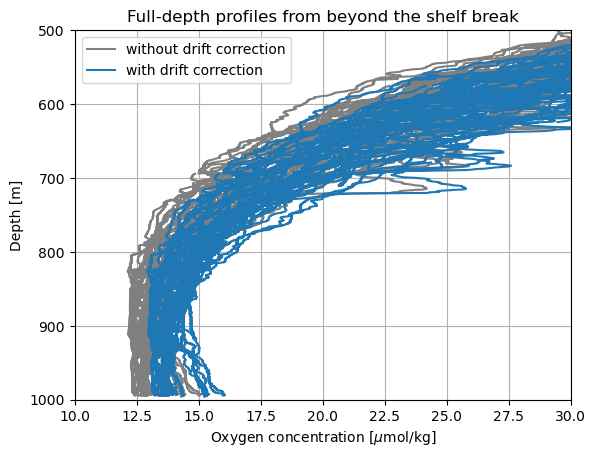

In [29]:
#Plotting full-depth profiles from beyond the shelfbreak
n0 = 417
n1 = 466
indp = np.logical_and(ds.profile_index>=n0, ds.profile_index<=n1)
plt.plot(ds.oxygen_concentration[indp]/dens0[indp]*1000,
         ds.depth[indp],'-',color='gray',label='without drift correction')
plt.plot(oxygen_drift[indp],
         ds.depth[indp],'-',label='with drift correction')
plt.ylabel('Depth [m]')
plt.xlabel('Oxygen concentration [$\mu$mol/kg]')
plt.ylim(1000, 500)
plt.xlim(10, 30)
plt.grid()
plt.legend()
plt.title('Full-depth profiles from beyond the shelf break')

print(f'The minimum oxygen value before the drift correction is {np.round(np.nanmin(ds.oxygen_concentration[indp]/dens0[indp]*1000),1)} umol/kg')
print(f'The minimum oxygen value after the drift correction is {np.round(np.nanmin(oxygen_drift[indp]),1)} umol/kg')

**Comparison of deep oxygen**: There are no good profiles to compare with during the glider mission. However, four DFO profiles of Winkler-titrated oxygen samples were collected during the same year and in the same general area. These profiles are not close enough in space or time to perform a drift correction, but can be used to examine deep oxygen values, as these vary on slow time scales. Three of profiles were collected near a nearby seamount on June 21st, 2021. Between 500 and 1000m, these profiles have minimum oxygen values of 11.9$\mu$mol/kg at 799m, 10.2$\mu$mol/kg at 949m, and 10.0$\mu$mol/kg at 890m. One additional profile was collected near where the glider crosses the shelf-break, but slightly further south, on June 3, 2021. This profile had a minimum oxygen value of 10.8$\mu$mol/kg at 989m. 

In general, the deep oxygen values from the bottle samples tend to be lower than the glider profiles. Given that sensor drift tends to cause low values, the drift correction has increased the disagreement with these deep samples.  

In [2]:
#Visualizing the drift correction
n0 = 417
n1 = 466
indp = np.logical_and(ds.profile_index>=n0, ds.profile_index<=n1)
fld_orig = ds.oxygen_concentration[indp]/dens0[indp]*1000
dp = ds.pressure[indp]
tm = ds.time[indp]
fld = oxygen_drift[indp]
sal = ds.salinity_adjusted[indp]

fig, ax = plt.subplots(1,2,constrained_layout=True, 
                            figsize=(10, 5))

ax1 = ax[0]
sc = ax1.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, c=fld[~np.isnan(fld)]-fld_orig[~np.isnan(fld)], marker='s', vmin=-15, vmax=0.5)
cb1 = plt.colorbar(sc, ax=ax1, orientation='vertical')
cb1.ax.tick_params(labelsize=12)
ax1.set_title('Drift correction - no drift correction')
ax1.set_xlabel('Time [day of month]',fontsize=12)
ax1.set_ylabel('Pressure [dbar]',fontsize=12)
ax1.invert_yaxis()
ax1.tick_params(labelsize=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax1.xaxis.set_tick_params(which='major', pad=10)

ax2 = ax[1]
ax2.grid()
ax2.scatter(fld[~np.isnan(fld)]-fld_orig[~np.isnan(fld)], dp[~np.isnan(fld)],  s=1, c='k')
ax2.set_title('Drift correction - no drift correction')
ax2.set_xlabel('Oxygen concentration difference [$\mu$mol/kg]',fontsize=12)
ax2.set_ylabel('Pressure [dbar]',fontsize=12)
ax2.invert_yaxis()
ax2.tick_params(labelsize=12)
ax2.xaxis.set_tick_params(which='major', pad=10)

NameError: name 'np' is not defined

#### Conclusion on drift correction

Given the lack of high-quality comparison profiles, and the conflicting supporting evidence for and against applying a drift correction, I am choosing **not** to apply a drift correction. However, I note that the optode on this glider was stored dry for several years after its last calibration and before this mission. As such, the data is likely to require a drift correction. 

Applying the drift correction would cause a change in oxygen concentration of between 0 and 5$\mu$mol/kg below 400m, and of less than 10$\mu$mol/kg below 150m. However above 150m, the difference would be up to nearly 20$\mu$mol/kg. 

**I conclude that the resulting 'corrected' oxygen should be considered to have high uncertainty.** 

In [156]:
ds['oxygen_adjusted'] = ds.oxygen_concentration.copy()
ds.oxygen_adjusted.values = oxygen_correct
ds['oxygen_adjusted'].attrs['units'] = 'umol L-1'
ds['oxygen_adjusted'].attrs['comment'] = 'Corrected oxygen concentration'
ds['oxygen_adjusted'].attrs['processing_report'] = processing_report
ds['oxygen_adjusted'].attrs['processing_date'] = processing_date
ds['oxygen_adjusted'].attrs['processing_protocol'] = processing_protocol

In [31]:
ds.to_netcdf(deploy_prefix+deploy_name+'_converted.nc')
print('Corrected data saved to file: '+deploy_prefix+deploy_name+'_converted.nc')

Corrected data saved to file: ./dfo-mike579-20210704/dfo-mike579-20210704_converted.nc


In [32]:
ds

<xarray.Dataset>
Dimensions:                (time: 1195042)
Coordinates:
  * time                   (time) datetime64[ns] 2021-07-04T17:58:49 ... 2021...
    latitude               (time) float64 nan 51.71 51.71 ... 51.31 51.31 51.31
    longitude              (time) float64 nan -128.1 -128.1 ... -129.1 -129.1
    depth                  (time) float64 nan 0.684 0.7435 ... 176.9 176.9 176.9
    pind                   (time) float64 ...
    profiles               float64 ...
Data variables: (12/26)
    heading                (time) float64 ...
    pitch                  (time) float64 ...
    roll                   (time) float64 ...
    waypoint_latitude      (time) float64 ...
    waypoint_longitude     (time) float64 ...
    conductivity           (time) float64 ...
    ...                     ...
    profile_direction      (time) float64 ...
    conductivity_adjusted  (time) float64 ...
    temperature_adjusted   (time) float64 nan nan nan nan ... nan nan nan nan
    salinity_adjusted      (time) float64 nan nan nan nan ... nan nan nan nan
    density_adjusted       (time) float64 ...
    oxygen_concentration   (time) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/65)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from Fisheries and Oceans Canada, Cana...
    cdm_data_type:             Trajectory
    comment:                   Calvert Island deployment
    contributor_name:          Hayley Dosser, Chris Payne, Stephanie Waterman
    ...                        ...
    summary:                   Glider deployed near Calvert Island BC in coll...
    time_coverage_end:         2021-08-04T00:10:45.000000000
    time_coverage_start:       2021-07-04T17:58:49.000000000
    title:                     dfo-mike579-20210704T1758
    transmission_system:       IRIDIUM
    wmo_id:                    4803927

In [33]:
import pyglider.ncprocess as ncprocess
#ncprocess.make_gridfiles(deploy_prefix+deploy_name+'_converted.nc',deploy_prefix,'deployment.yml',fnamesuffix='_converted')

SyntaxError: iterable argument unpacking follows keyword argument unpacking (609090825.py, line 2)

jupyter nbconvert Oxygen_dfo-mike579-20210704.ipynb --to=webpdf --TemplateExporter.exclude_input=True